In [1]:
library(rstan)
library(tidyverse)
library(HDInterval)
library(coda)
library(forecast)
library(tseries)
library(ggplot2)

Warning message:
“package ‘rstan’ was built under R version 4.3.3”
Loading required package: StanHeaders

Warning message:
“package ‘StanHeaders’ was built under R version 4.3.3”

rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


── Attaching core tidyverse packages ──────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────── tidyverse_conflict

### Problem 1

#### 1a

In [2]:
#–– setup --------------------------------------------------------------------
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

#–– load data ---------------------------------------------------------------
dat <- read.csv("./data/HW6-TherapeuticTouchData.csv", header=TRUE)
# the file has columns "y" (0/1) and "s" (practitioner index)
counts <- dat %>%
  group_by(s) %>%
  summarize(y = sum(y), n = n()) %>%
  arrange(s)

N <- nrow(counts)         # should be 28
y <- counts$y
n <- counts$n
data_list <- list(N=N, y=y, n=n)

In [3]:
#–– Model 1 Stan code -------------------------------------------------------
model1_code <- "
data {
  int<lower=1> N;
  int<lower=0> y[N];
  int<lower=0> n[N];
}
parameters {
  vector<lower=0,upper=1>[N] theta;
}
model {
  theta ~ beta(9,2);
  y ~ binomial(n, theta);
}
generated quantities {
  real diff_contrast = max(theta) - min(theta);
}

"
writeLines(model1_code, "model1_tt.stan")
sm1 <- stan_model("model1_tt.stan")

In [4]:
fit1 <- sampling(sm1, data=data_list, iter=2000, chains=4, 
                 control=list(adapt_delta=0.95))
post1 <- rstan::extract(fit1)
d1    <- post1$diff_contrast
cat("**Model 1** (independent Beta(9,2))\n")
cat("  E[θ_N − θ_1] =", mean(d1), 
    "  95% CI =", quantile(d1, c(0.025,0.975)), "\n\n")


**Model 1** (independent Beta(9,2))
  E[θ_N − θ_1] = 0.5007867   95% CI = 0.3654332 0.6517198 



#### 1b

In [5]:
model2_code <- "
data {
  int<lower=1> N;
  int<lower=0> y[N];
  int<lower=0> n[N];
}
parameters {
  real<lower=0> a;
  real<lower=0> b;
  vector<lower=0,upper=1>[N] theta;
}
model {
  a ~ exponential(1);
  b ~ exponential(1);
  theta ~ beta(a,b);
  y ~ binomial(n, theta);
}
generated quantities {
  real diff_contrast = theta[N] - theta[1];
  real group_mode = (a - 1) / (a + b - 2);
}

"
writeLines(model2_code, "model2_tt.stan")
sm2 <- stan_model("model2_tt.stan")
fit2 <- sampling(sm2, data=data_list, iter=2000, chains=4, 
                 control=list(adapt_delta=0.95))


In [6]:
post2 <- rstan::extract(fit2)
d2    <- post2$diff_contrast
cat("**Model 2** (hierarchical)\n")
cat("  E[θ_N − θ_1] =", mean(d2), 
    "  95% CI =", quantile(d2, c(0.025,0.975)), "\n")

**Model 2** (hierarchical)
  E[θ_N − θ_1] = 0.4247464   95% CI = 0.09904824 0.7088304 


#### 1c

In [7]:
# turn gm into an mcmc with one named column
gm    <- post2$group_mode

gm_mcmc <- as.mcmc(matrix(gm,
                          ncol = 1,
                          dimnames = list(NULL, "group_mode")))

# compute the 95% HPD interval
hpdi <- HPDinterval(gm_mcmc, prob = 0.95)["group_mode", ]

# also get a posterior mean
gm_mean <- mean(gm)

cat("Model 2 group‐mode posterior:\n")
cat("  mean(mode)   =", gm_mean, "\n")
cat("  95% HPDI     = [", hpdi[1], ", ", hpdi[2], "]\n", sep="")

if (hpdi[1] < 0.5 && hpdi[2] > 0.5) {
  cat("→ 0.5 is inside the 95% HPDI ⇒ group accuracy ≈ chance.\n")
} else {
  cat("→ 0.5 is outside the 95% HPDI ⇒ group accuracy differs from chance.\n")
}

Model 2 group‐mode posterior:
  mean(mode)   = 0.4177787 
  95% HPDI     = [0.2869908, 0.5493955]
→ 0.5 is inside the 95% HPDI ⇒ group accuracy ≈ chance.


### Problem 2

#### 2c

In [8]:
#--- load data -----------------------------------------------------
# adjust header=TRUE/FALSE to match your file
dat <- read.table("./data/HW6-house.txt", header=T)
names(dat) <- c("Y","X")
Y <- dat$Y
x <- dat$X
n <- length(Y)

#--- set up design matrix ------------------------------------------
X <- cbind(1, x, x * x)
XtX <- crossprod(X)        # X'X
XtXinv <- solve(XtX)
XtY <- crossprod(X, Y)     # X'Y
beta_hat <- XtXinv %*% XtY # OLS estimate

#--- compute SSE ---------------------------------------------------
resid <- Y - X %*% beta_hat
SSE  <- sum(resid^2)

#--- draw iid posterior sample ------------------------------------
library(MASS)  # for mvrnorm
R <- 1000
betas   <- matrix(NA, nrow=R, ncol=3)
sig2    <- numeric(R)
xmin    <- numeric(R)

for (i in 1:R) {
  # draw sigma2
  sig2[i] <- 1 / rgamma(1,
                shape=(n-3)/2,
                rate = SSE/2)
  # draw beta
  betas[i,] <- as.vector(
    mvrnorm(1, mu=beta_hat, Sigma=sig2[i]*XtXinv)
  )
  # compute minimizer
  xmin[i] <- -betas[i,2] / (2*betas[i,3])
}

#--- posterior summaries ------------------------------------------
mean(xmin)
quantile(xmin, c(0.025,0.975))



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




[1] 42.65463

2.5%    97.5% 
37.03645 52.80119

#### 2d

In [9]:
#--- Gibbs sampler ----------------------------------------------
R       <- 5000
burn    <- 1000
beta_g  <- matrix(NA, nrow=R, ncol=3)
sig2_g  <- numeric(R)
xmin_g  <- numeric(R)

# initialize
sig2_g[1]  <- SSE / (n-3)    # or any positive value
beta_g[1,] <- beta_hat

for (i in 2:R) {
  # 1) draw beta | sigma2, y
  Sigma_beta <- sig2_g[i-1] * XtXinv
  beta_g[i,] <- as.vector(
    mvrnorm(1, mu=beta_hat, Sigma=Sigma_beta)
  )

  # 2) draw sigma2 | beta, y
  resid2 <- Y - X %*% beta_g[i,]
  shape  <- n/2
  rate   <- sum(resid2^2)/2
  sig2_g[i] <- 1 / rgamma(1, shape=shape, rate=rate)

  # 3) store minimizer
  xmin_g[i] <- -beta_g[i,2] / (2*beta_g[i,3])
}

# discard burn-in
post_xmin <- xmin_g[-(1:burn)]

# summaries
mean(post_xmin)
quantile(post_xmin, c(0.025,0.975))

[1] 42.98028

2.5%    97.5% 
36.93123 53.44619

### Problem 4

#### 4a

In [10]:
# Load the data
milk <- read.csv("https://raw.githubusercontent.com/ourcodingclub/CC-time-series/master/monthly_milk.csv")

# Check structure
str(milk)

'data.frame':	168 obs. of  2 variables:
 $ month               : chr  "1962-01-01" "1962-02-01" "1962-03-01" "1962-04-01" ...
 $ milk_prod_per_cow_kg: num  265 252 288 295 327 ...


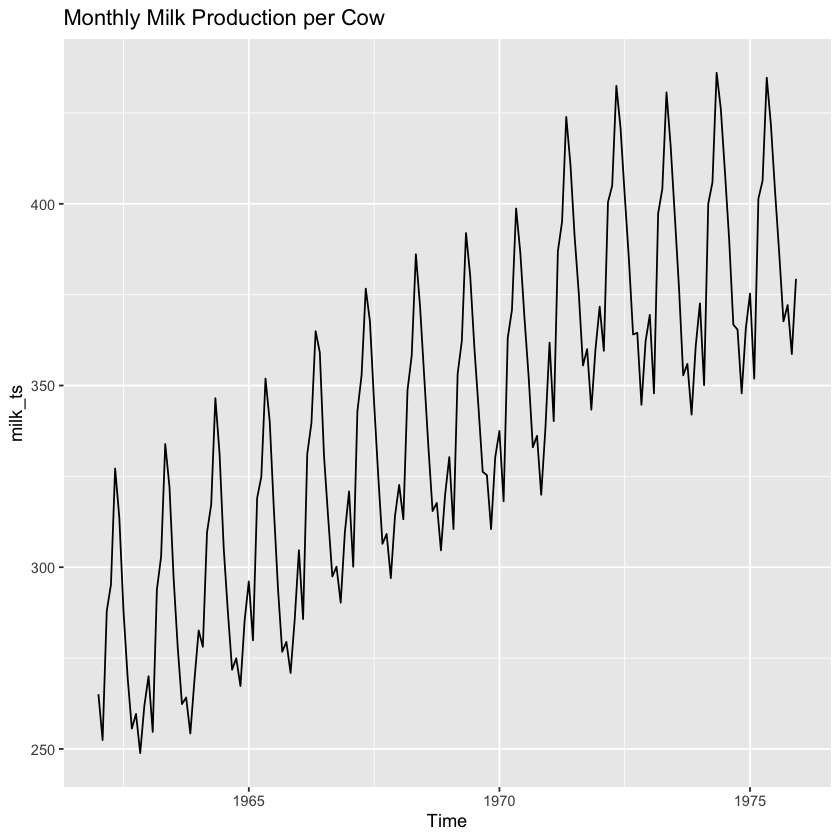

In [11]:
# Convert to time series object
milk_ts <- ts(milk$milk_prod_per_cow_kg, start=c(1962,1), frequency=12)

# Plot the data
autoplot(milk_ts) + ggtitle("Monthly Milk Production per Cow")

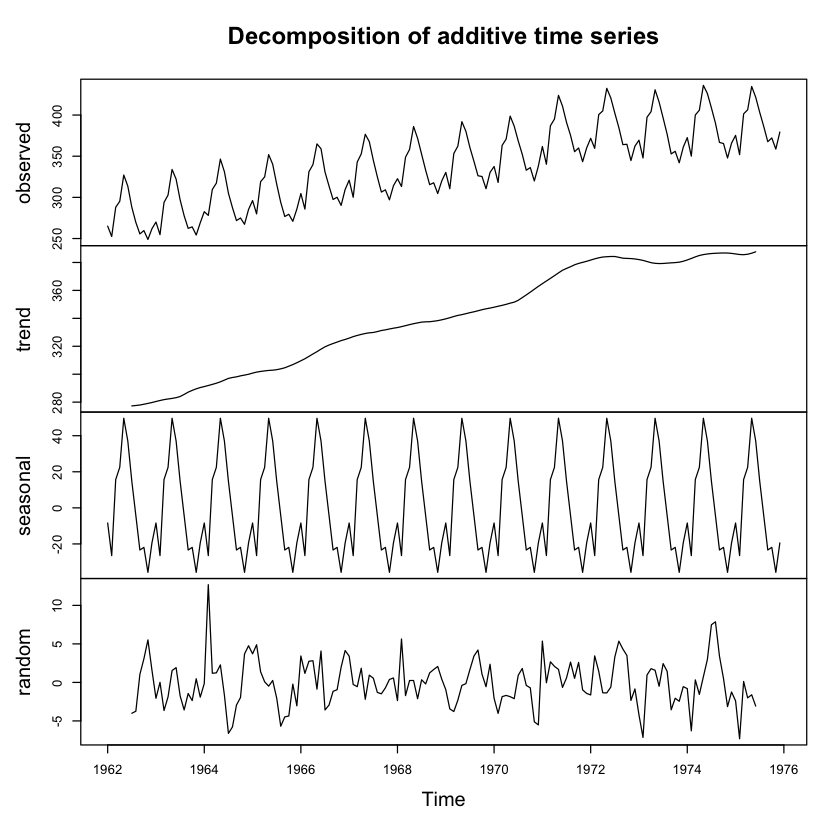

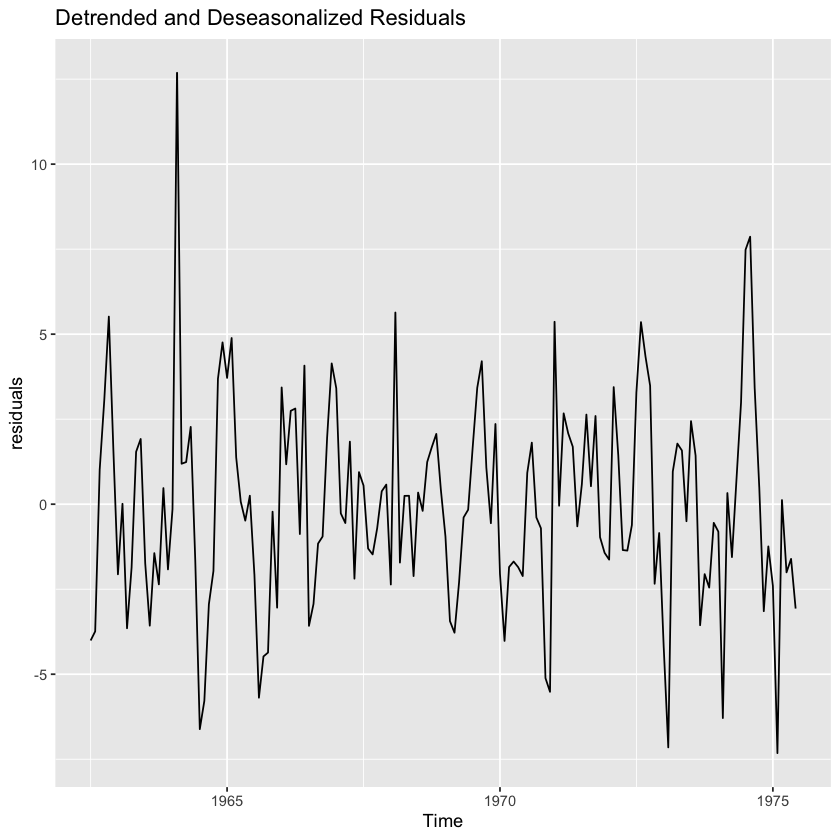

In [12]:
# Decompose time series
decomposed <- decompose(milk_ts)

# Plot decomposition
plot(decomposed)

# Remove trend and seasonality
residuals <- decomposed$random

# Remove NA values (resulting from decomposition)
residuals <- na.omit(residuals)

# Plot residuals
autoplot(residuals) + ggtitle("Detrended and Deseasonalized Residuals")

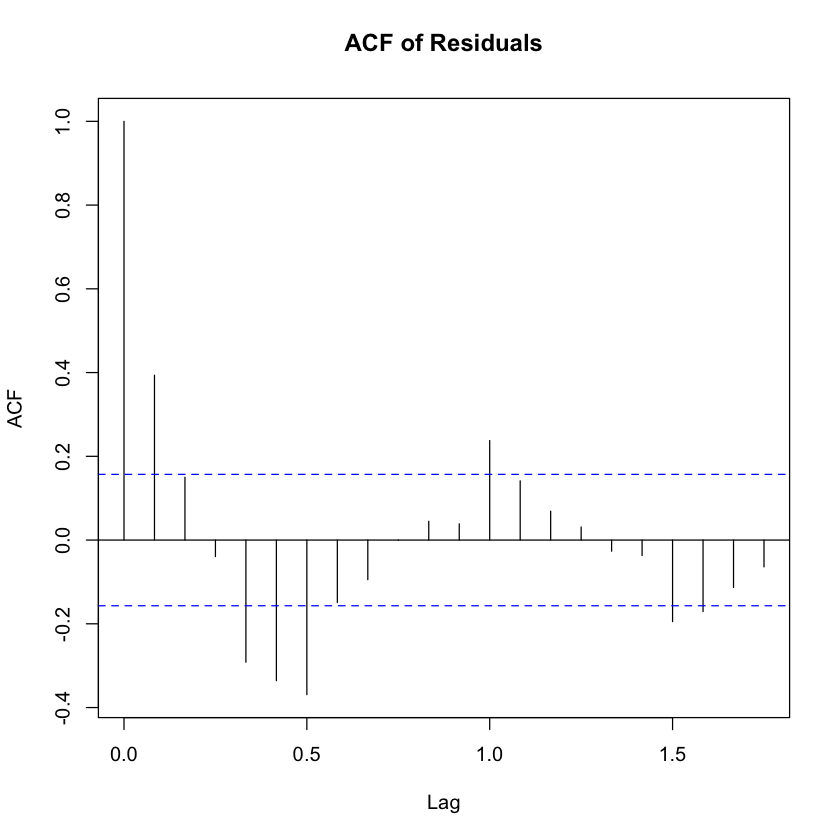

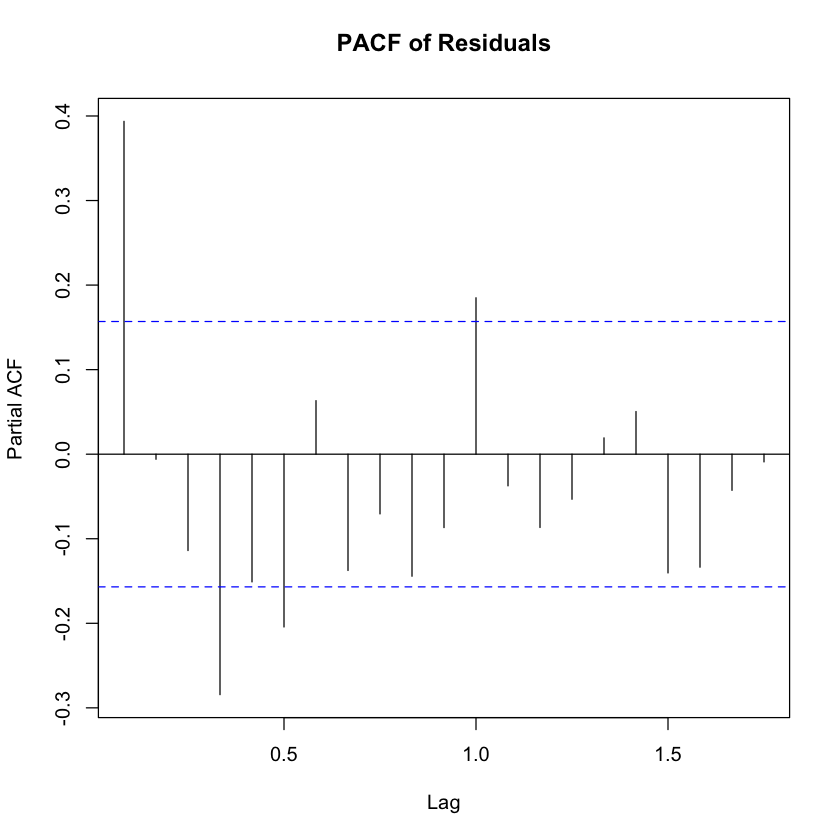

In [13]:
# ACF and PACF
acf(residuals, main="ACF of Residuals")
pacf(residuals, main="PACF of Residuals")

**Comments:** 
In ACF plot, there’s a moderately large positive spike at lag 1, and thereafter the autocorrelations die away roughly exponentially (with maybe a very small blip at lag 12 that you can probably ignore).

In PACF plot, there is a single strong partial autocorrelation at lag 1 and essentially nothing beyond that (again, apart from a tiny, marginal 12-month spike).

This “ACF tails off, PACF cuts off after lag 1” pattern is the classic signature of an AR(1) process.

#### 4b

,df,AIC
,<dbl>,<dbl>
ar1,3,766.9031
ar2,4,768.9019
ma1,3,770.5476
ma2,4,769.2955


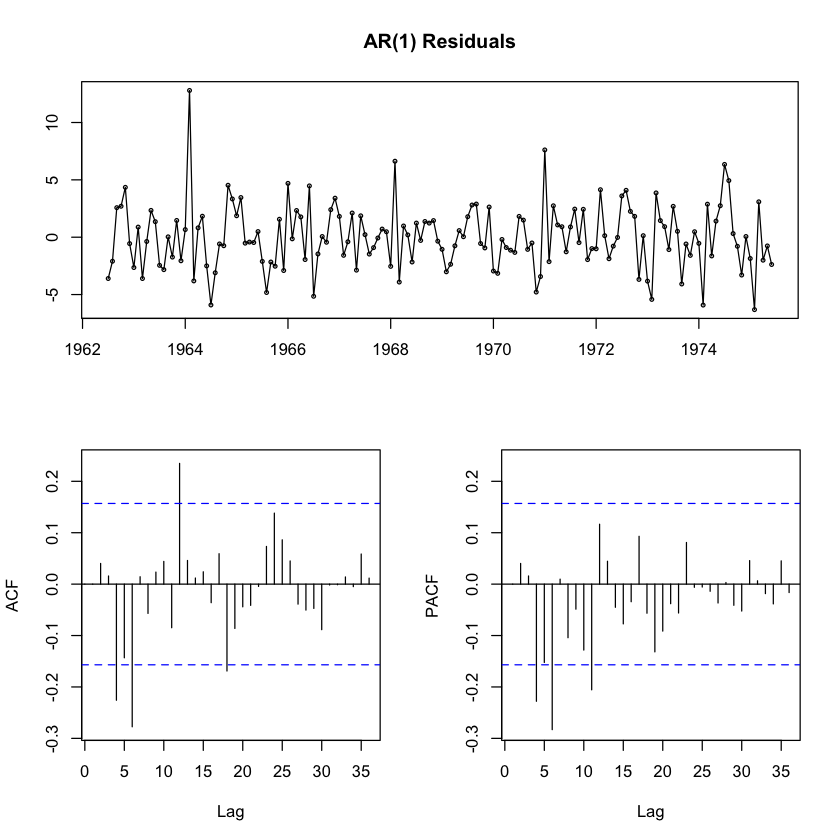

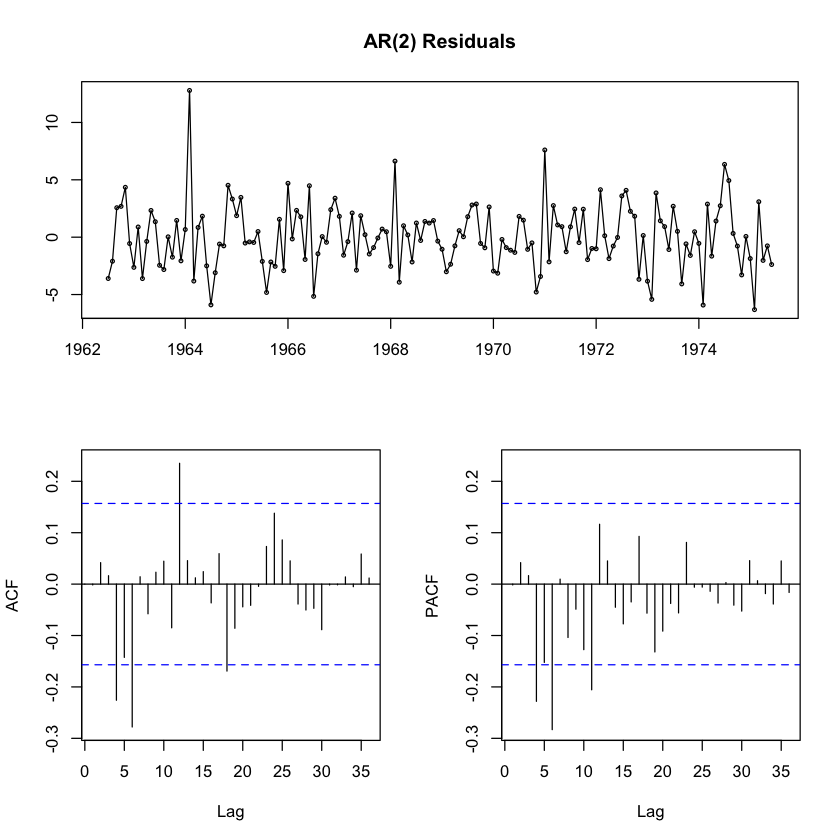

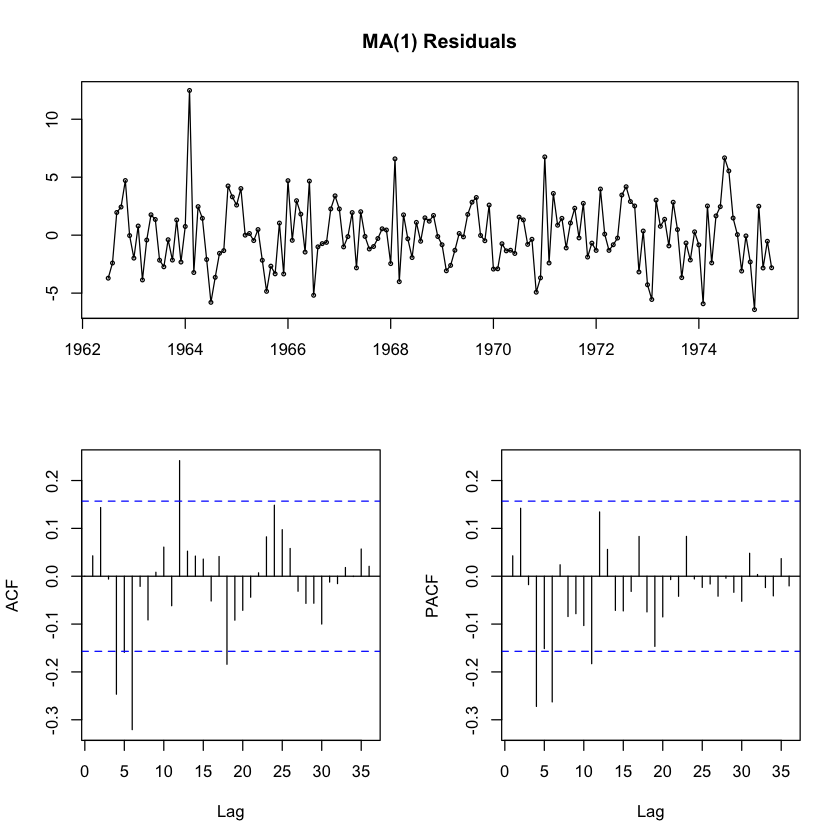

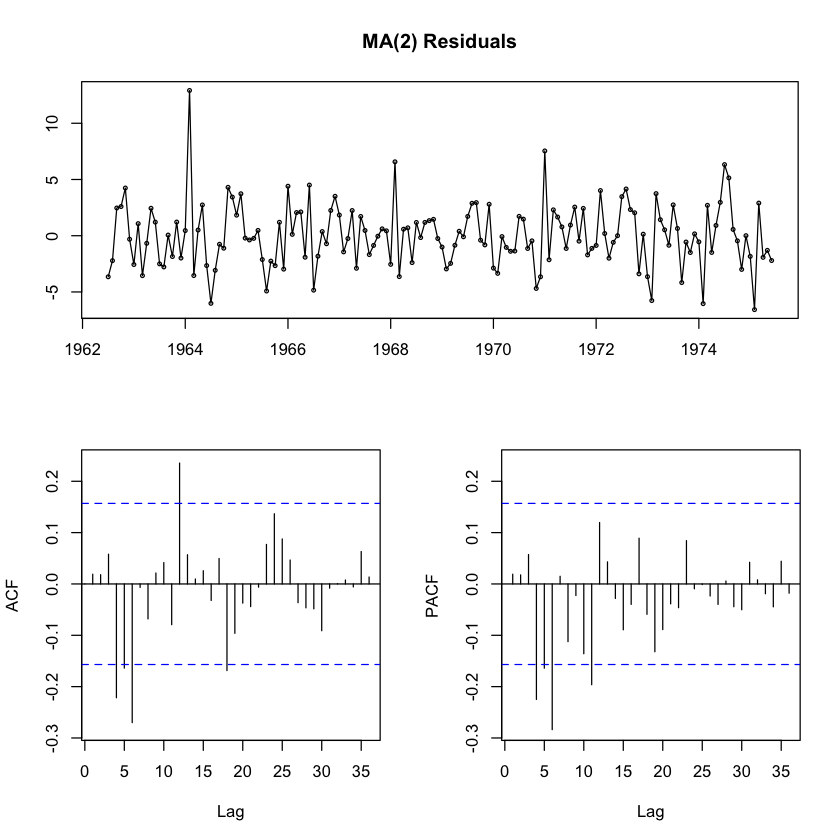

In [14]:
# Fit models
ar1 <- arima(residuals, order=c(1,0,0))
ar2 <- arima(residuals, order=c(2,0,0))
ma1 <- arima(residuals, order=c(0,0,1))
ma2 <- arima(residuals, order=c(0,0,2))

# Compare models
AIC(ar1, ar2, ma1, ma2)

# Check residuals for white noise
tsdisplay(residuals(ar1), main="AR(1) Residuals")
tsdisplay(residuals(ar2), main="AR(2) Residuals")
tsdisplay(residuals(ma1), main="MA(1) Residuals")
tsdisplay(residuals(ma2), main="MA(2) Residuals")

In [15]:
Box.test(residuals(ar1), lag = 12, type = "Ljung-Box")
Box.test(residuals(ar2), lag = 12, type = "Ljung-Box")
Box.test(residuals(ma1), lag = 12, type = "Ljung-Box")
Box.test(residuals(ma2), lag = 12, type = "Ljung-Box")


	Box-Ljung test

data:  residuals(ar1)
X-squared = 36.228, df = 12, p-value = 0.0002977



	Box-Ljung test

data:  residuals(ar2)
X-squared = 36.3, df = 12, p-value = 0.0002899



	Box-Ljung test

data:  residuals(ma1)
X-squared = 47.194, df = 12, p-value = 4.314e-06



	Box-Ljung test

data:  residuals(ma2)
X-squared = 36.694, df = 12, p-value = 0.0002504


**Comments:** 
The AR(1) has the lowest AIC of the four, so it is the “best” in the sense of in‐sample fit/penalty balance.

Residual‐ACF/PACF of AR(1) has no spikes exceed the limits (aside from tiny, insignificant blips), and the series looks like uncorrelated noise. AR(2), MA(1), MA(2) residuals show very similar randomness, but none of them lowered the AIC below the AR(1).

From the Box-Ljung test result, every model can reject the null hypothesis that "all autocorrelations up to lag 12 are zero" in 0.05 significance level.

#### 4c

,df,AIC
,<dbl>,<dbl>
arma11,4,768.9024
arma21,5,768.9540
arma12,5,770.1001
arma22,6,743.9746


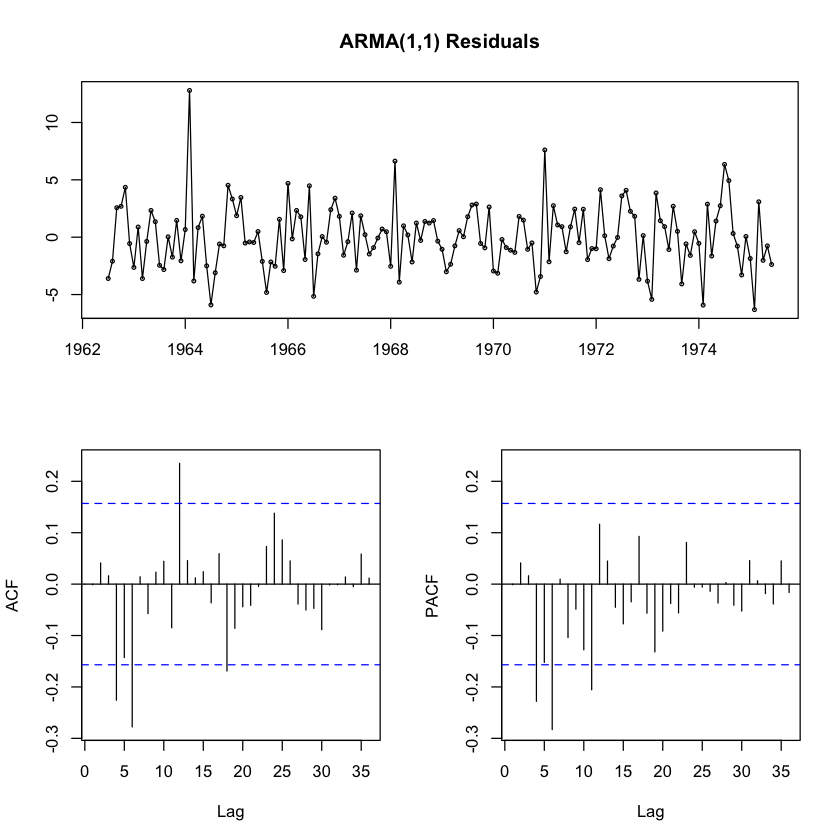

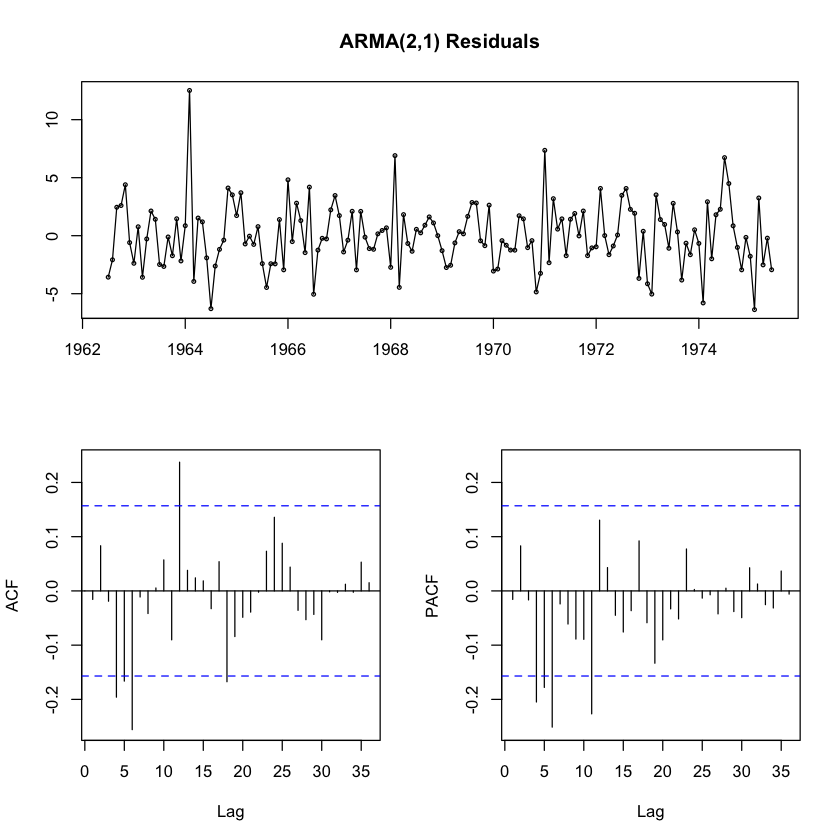

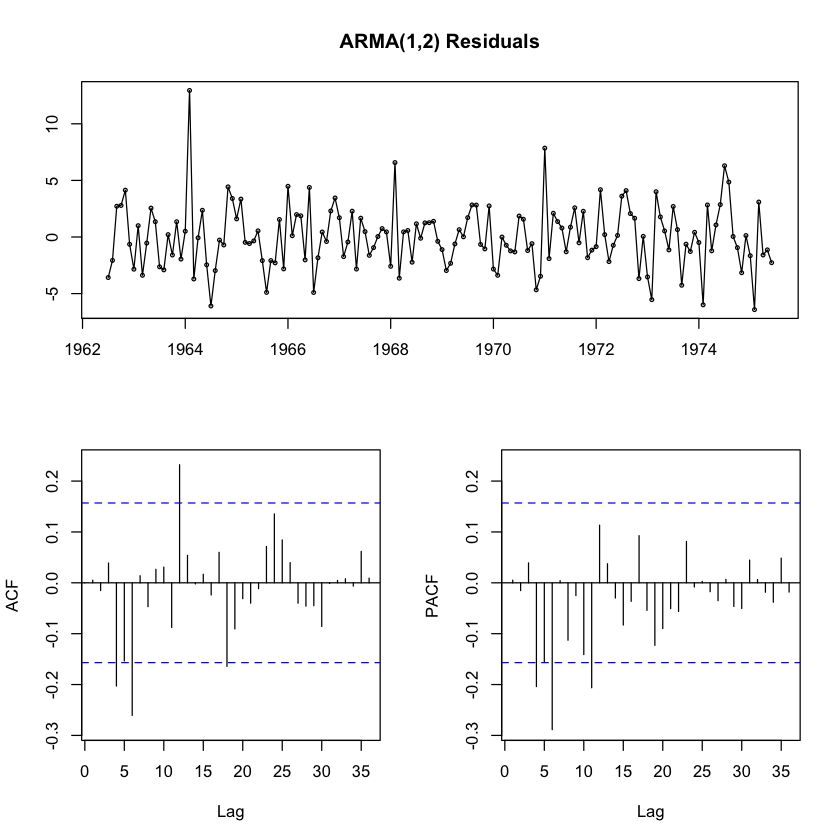

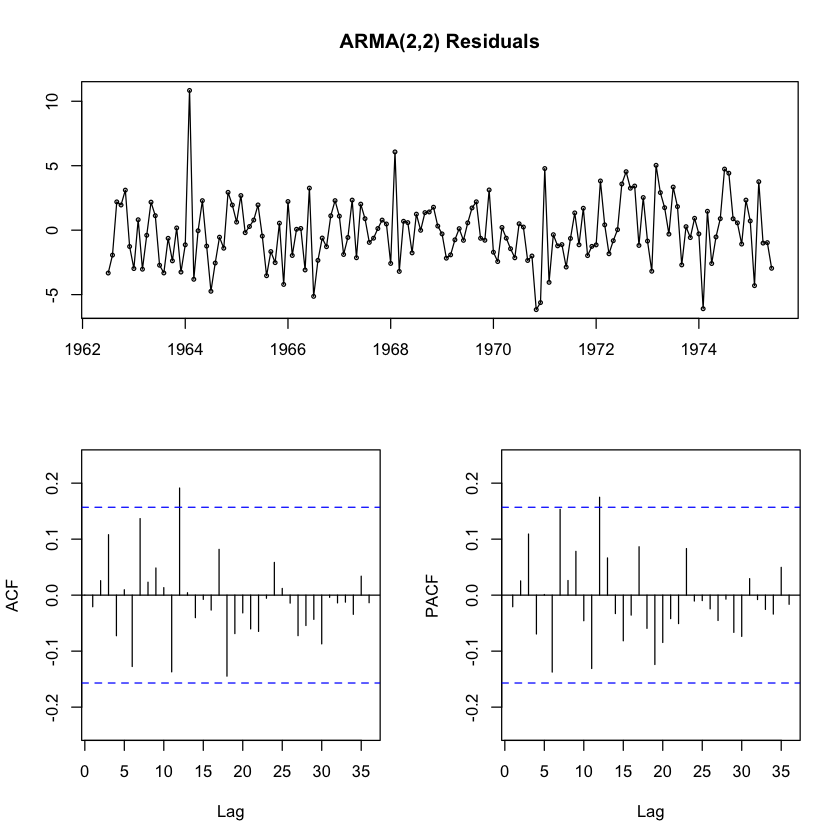

In [16]:
# Try some ARMA models
arma11 <- arima(residuals, order=c(1,0,1))
arma21 <- arima(residuals, order=c(2,0,1))
arma12 <- arima(residuals, order=c(1,0,2))
arma22 <- arima(residuals, order=c(2,0,2))

# Compare
AIC(arma11, arma21, arma12, arma22)

# Check residuals
tsdisplay(residuals(arma11), main="ARMA(1,1) Residuals")
tsdisplay(residuals(arma21), main="ARMA(2,1) Residuals")
tsdisplay(residuals(arma12), main="ARMA(1,2) Residuals")
tsdisplay(residuals(arma22), main="ARMA(2,2) Residuals")

In [17]:
Box.test(residuals(arma11), lag = 12, type = "Ljung-Box")
Box.test(residuals(arma21), lag = 12, type = "Ljung-Box")
Box.test(residuals(arma12), lag = 12, type = "Ljung-Box")
Box.test(residuals(arma22), lag = 12, type = "Ljung-Box")


	Box-Ljung test

data:  residuals(arma11)
X-squared = 36.274, df = 12, p-value = 0.0002928



	Box-Ljung test

data:  residuals(arma21)
X-squared = 34.582, df = 12, p-value = 0.0005458



	Box-Ljung test

data:  residuals(arma12)
X-squared = 33.176, df = 12, p-value = 0.0009086



	Box-Ljung test

data:  residuals(arma22)
X-squared = 18.642, df = 12, p-value = 0.09754


**Comments**: 

ARMA(2,2) (equivalently ARIMA(2,0,2) on detrended & deseasonalized data) is the best ARIMA model. Because it has lowest AIC, approximately-random residuals in ACF/PACF plots. And its Ljung–Box p-value comfortably above 0.05, confirming they behave like white noise.